# Univariate Time Series

## Notebook
Author: Pepar Hugo

Date: September 23, 2020

## Requirements

This notebook follows the outline provided in MScFE 610 Econ Group Work Projects:

With this data, do the following using R or Python languages: 
1. Forecast S&P/Case-Shiller U.S. National Home Price Index using an ARMA model. 
2. Implement the Augmented Dickey-Fuller Test for checking the existence of a unit root in Case-Shiller Index series. 
3. Implement an ARIMA(p,d,q) model. Determine p, d, q using Information Criterion or Box-Jenkins methodology. Comment the results.  
4. Forecast  the  future  evolution  of  Case-Shiller  Index  using  the  ARMA  model.  Test  model  using in-sample forecasts.

## Data

Data source: [https://fred.stlouisfed.org/series/CSUSHPISA](https://fred.stlouisfed.org/series/CSUSHPISA)

Period considered in the analysis: January 1987 – latest data

Frequency: monthly data

## References

- Brownlee, Jason. "How to Create an ARIMA Model for Time Series Forecasting in Python". August 19, 2020. https://machinelearningmastery.com/arima-for-time-series-forecasting-with-python/. [Online; accessed 2020-09-23].
- Ismiguzel, Idil. "Hands-on Time Series Forecasting with Python". June 1, 2020. https://towardsdatascience.com/hands-on-time-series-forecasting-with-python-d4cdcabf8aac. [Online; accessed 2020-09-25].
- Pedregosa et al. Scikit-learn: Machine Learning in Python, JMLR 12, pp. 2825-2830, 2011. http://jmlr.csail.mit.edu/papers/v12/pedregosa11a.html. [Online; accessed 2020-09-27].
 -  https://scikit-learn.org/stable/index.html. [Online; accessed 2020-09-27].
- Smith, Taylor G., et al. pmdarima: ARIMA estimators for Python, 2017-, http://www.alkaline-ml.com/pmdarima [Online; accessed 2020-09-27].



## Import Libraries

In [1]:
import requests
import pandas as pd
import numpy as np
from io import StringIO
import matplotlib.pyplot as plt
%matplotlib inline
import matplotlib
import seaborn as sns
plt.style.use('fivethirtyeight')
#library to provide seasonal decompositon of data
import statsmodels.api as sm
from statsmodels.tsa.seasonal import seasonal_decompose
#library to run auto-correlation and partial autocorrelation plots
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
#library for Augmented Dickey-Fuller Test
from statsmodels.tsa.stattools import adfuller
#library for information criterion
import pmdarima as pm
#library for ARMIMA forecast
from statsmodels.tsa.arima.model import ARIMA
#library for model scoring
from sklearn.metrics import mean_squared_error, explained_variance_score, mean_absolute_error

## Get Data
I am pulling the csv data directly through a request. I used the browser `Inspect` function on [this page](https://fred.stlouisfed.org/series/CSUSHPISA) to see what url request downloaded the csv data. I copied that link and parased out the request parameters below into a dictionary called `params`. The params are passed in with csv url using `requests.get()` to download in the csv data.

In [2]:
params={'bgcolor': '%23e1e9f0',
 'chart_type': 'line',
 'drp': '0',
 'fo': 'open%20sans',
 'graph_bgcolor': '%23ffffff',
 'height': '450',
 'mode': 'fred',
 'recession_bars': 'on',
 'txtcolor': '%23444444',
 'ts': '12',
 'tts': '12',
 'width': '1168',
 'nt': '0',
 'thu': '0',
 'trc': '0',
 'show_legend': 'yes',
 'show_axis_titles': 'yes',
 'show_tooltip': 'yes',
 'id': 'CSUSHPISA',
 'scale': 'left',
 'cosd': '1987-01-01',
 'coed': '2020-06-01',
 'line_color': '%234572a7',
 'link_values': 'false',
 'line_style': 'solid',
 'mark_type': 'none',
 'mw': '3',
 'lw': '2',
 'ost': '-99999',
 'oet': '99999',
 'mma': '0',
 'fml': 'a',
 'fq': 'Monthly',
 'fam': 'avg',
 'fgst': 'lin',
 'fgsnd': '2020-02-01',
 'line_index': '1',
 'transformation': 'lin',
 'vintage_date': '2020-09-23',
 'revision_date': '2020-09-23',
 'nd': '1987-01-01'}
url = 'https://fred.stlouisfed.org/graph/fredgraph.csv'
resp = requests.get(url=url,params=params)

## Read data into a pandas dataframe & visualize the data
Pandas `read_csv` needs a string input output function `StringIO` from library `io` to read the csv data loaded into the response from csv request above. Usually the `read_csv` funtions takes a path to a csv file but I by passed save and reloading the data using the `StringIO` function.

Results:

From 2012 to today the data has a linear trend but prior to the 2008 drop is appears to have a non-linear trend.

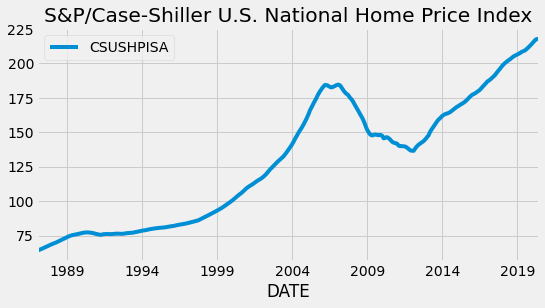

In [3]:
data= pd.read_csv(StringIO(resp.text),sep=',',parse_dates=['DATE'], index_col='DATE')
data.plot(figsize=(8,4))
plt.title('S&P/Case-Shiller U.S. National Home Price Index')
plt.show()

In [4]:
#see descirpion data to summarize the distribution of the data
data.describe()

,CSUSHPISA
count,402.000000
mean,128.841781
std,45.682091
min,63.989000
25%,80.737500
50%,136.413000
75%,168.617250
max,218.058000


## Run a seasonal decomposition to see trend, seaonal and residual components
This section of the code passes the pandas dataframe `data` into an additive seasonal decomposition.

Notes:
There is little to no seaonal component since it ranges between -0.05 to 0.05 relative to the range of actual values from 64 to 218. The residual also has a wave pattern, which is most likely negatively correlated with seasonal component. It is possible to take the decomposition output and run a correlation matrix to see if the seasonal component and the residual component are correlated but this is outside the scope of this assignment so I will not run the correlation matrix.

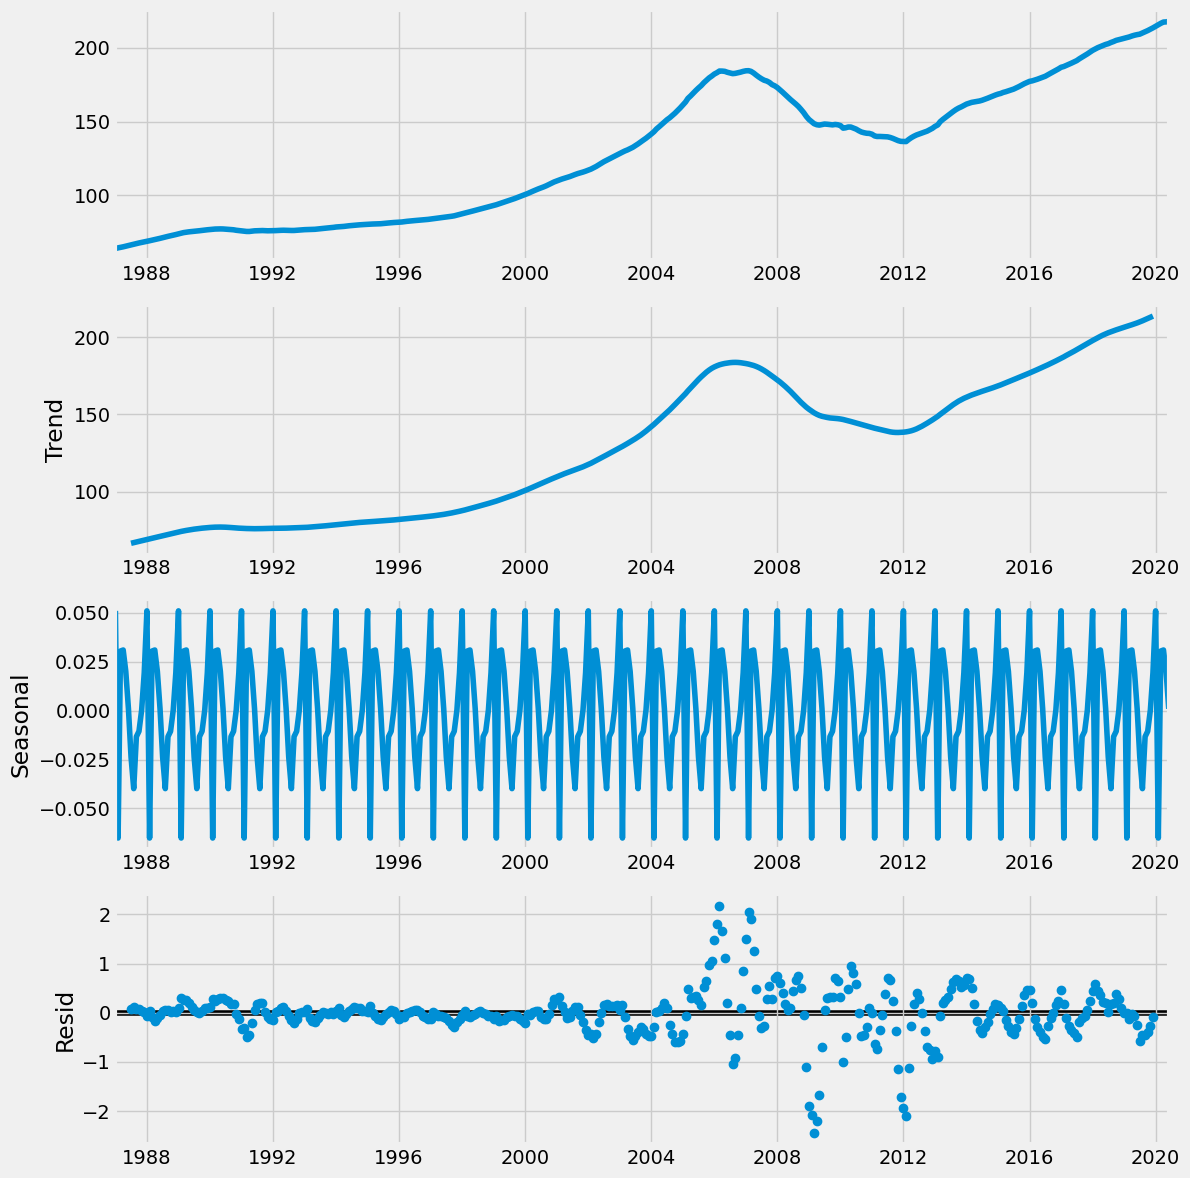

In [5]:
#selected additive model since 2012 displays linear trend 
plt.rcParams['figure.figsize'] = [12, 12]
plt.rcParams['figure.dpi'] = 100 
decomp = seasonal_decompose(data, model='additive')
decomp.plot()
plt.show()

# 1. Forecast S&P/Case-Shiller U.S. National Home Price Index using an ARMA model
## Run an acf and pacf plot
The code below runs a acf and pacf data.

Results:
The acf decays overtime following a linear trend and the pacf spikes through 2 lags. This means this is AR(2).
The ARMA model will be (2,0,0).

This assumes the data is stationary.

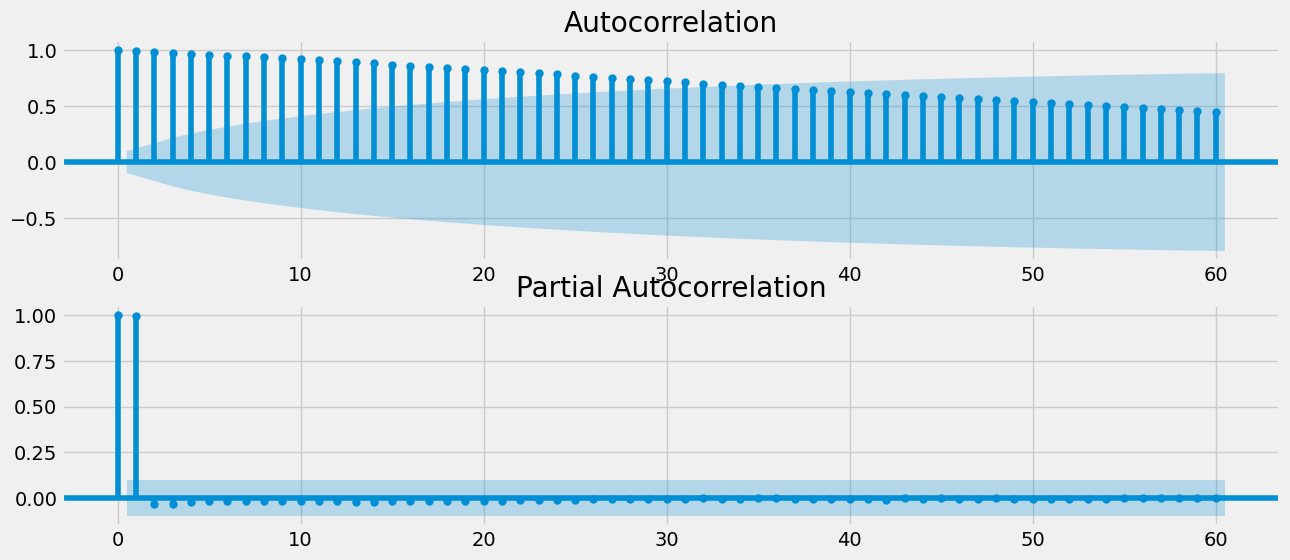

In [6]:
fig, (ax1, ax2) = plt.subplots(nrows=2, ncols=1, figsize=(14,6), sharex=False, sharey=False)
plot_acf(data, lags=60, ax=ax1)
plot_pacf(data, lags=60, ax=ax2)
plt.show()

# ARMA Forecast
The initial ARMA forecast using (2,0,0). I will forecast 36 months out because the full dataset is 402 records. 36 months will show the forecast trend relative to the full 402 data points.

Results:

The trend forecast is clearly dampened. I will try an Augmented Dickey-Fuller Test to see if the data is stationary. The null hypthesis of the Augmented Dickey-Fuller Test is the data is not stationary.

In [7]:
model_1 = ARIMA(data, order=(2,0,0),freq='MS')
model_fit = model_1.fit()
output_1 = model_fit.forecast(steps=36,freq='MS')

/Users/pepar-mapillary/anaconda3/envs/monthly-report/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


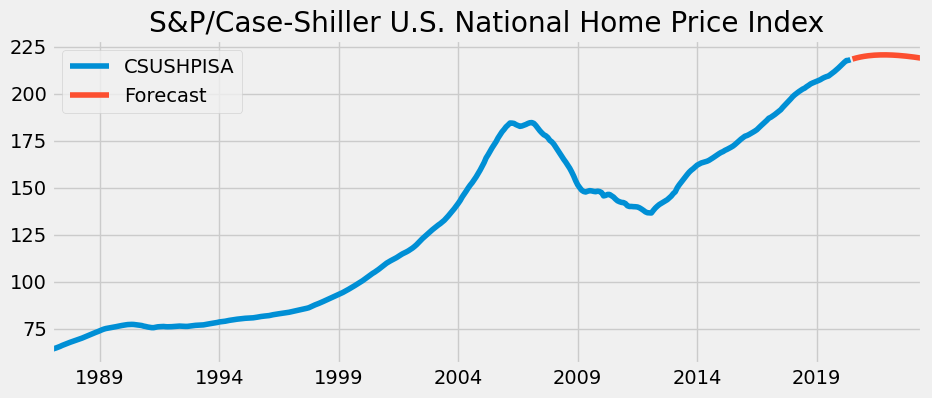

In [8]:
forecast_1 = data.copy()
forecast_1 = pd.concat([forecast_1,output_1],axis=1)
forecast_1.columns = [forecast_1.columns[0], 'Forecast']
forecast_1.plot(figsize=(10,4))
plt.title('S&P/Case-Shiller U.S. National Home Price Index')
plt.show()

# 2.Implement the Augmented Dickey-Fuller Test for checking the existence of a unit root in Case-Shiller Index series
## Augmented Dickey-Fuller Test 

Results:

**Test 1**

We failed to reject the null hypthesis because p-value=0.903413>0.05. This means the data is not stationary.

**Test 2**

We rejected the null hypthesis because p-value=0.049176<0.05. This means the data is stationary at p-value<0.05 but it is not stationary at p-value>0.01.

In [9]:
#Test1
dftest_1 = adfuller(data)
dftest_1_output = pd.Series(dftest_1[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
for key, value in dftest_1[4].items():
    dftest_1_output['Critical Value (%s)'%key] = value
print(dftest_1_output)

Test Statistic                  -0.438818
p-value                          0.903413
#Lags Used                      14.000000
Number of Observations Used    387.000000
Critical Value (1%)             -3.447361
Critical Value (5%)             -2.869037
Critical Value (10%)            -2.570764
dtype: float64


In [10]:
#Test2
dftest_2 = adfuller(data.diff().dropna())
dftest_2_output = pd.Series(dftest_2[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
for key, value in dftest_2[4].items():
    dftest_2_output['Critical Value (%s)'%key] = value
print(dftest_2_output)

Test Statistic                  -2.868175
p-value                          0.049176
#Lags Used                      13.000000
Number of Observations Used    387.000000
Critical Value (1%)             -3.447361
Critical Value (5%)             -2.869037
Critical Value (10%)            -2.570764
dtype: float64


# 3. Implement an ARIMA(p,d,q) model. Determine p, d, q using Information Criterion or Box-Jenkins methodology. Comment the results.
## ARIMA Forecast
Steps:

1. Plot acf and pacf for differencing 1.
2. Examine plots to see if AR, MA or AR & MA for p and q values.
3. Create ARIMA model with (p,d,q).
4. Forecast values.
5. Plot Actuals and Forecast.
6. Grid search for p and q using AIC minimzing objective.
7. Forecast and plot AIC criterion.

Results:

Box-Jenkins method parameters
- p = 2 since pacf has significant spike at lag 2
- d = 1 since Augmented Dickey-Fuller Test was significant at 1 time differencing
- q = 0 since the acf shows linear decay

Information Criterion method parameters using a step search. The step search will select the model that minimizes AIC. 
- p = 2
- d = 1 since Augmented Dickey-Fuller Test was significant at 1 time differencing
- q = 1

Comments:

Both the Box-Jenkins (2,1,0) and Information Criterion (2,1,1) methods have damped trends but it decays at a slower rate than the ARMA of (2,0,0). I would say that these models need far more work and validation before a long-term forecast can be generated. Based on the output I would say the trend is being dampened too much and further analysis is required if a forecast model is required for long-term forecasting.

When I say long-term forecasting, I mean anything above 1 month incremental forecasts.

## Box-Jenkins Method

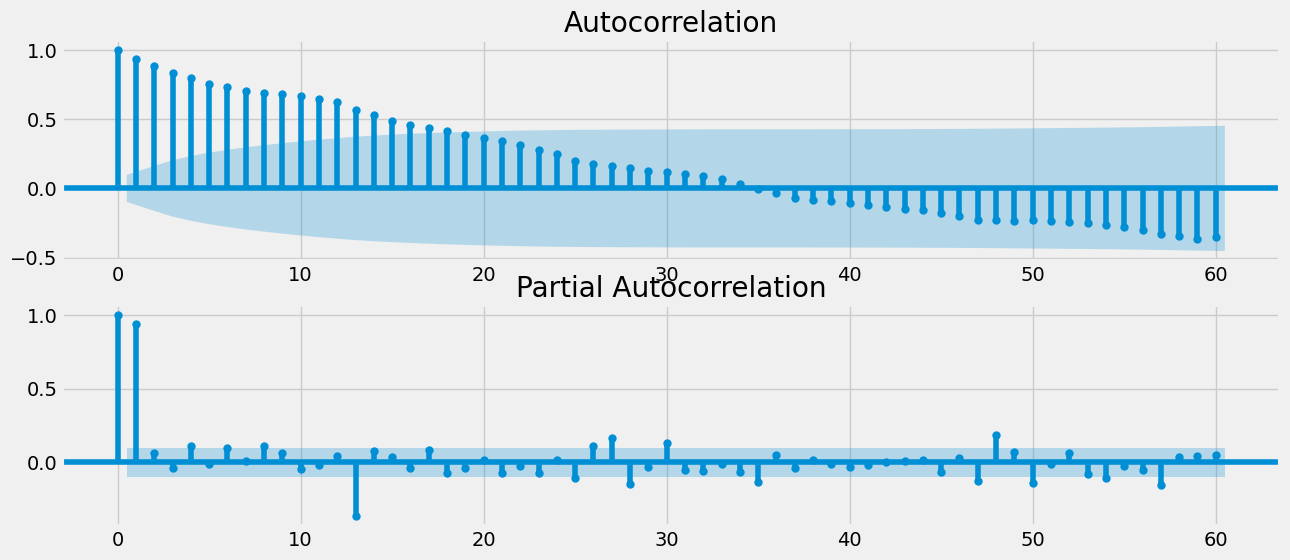

In [11]:
fig, (ax1, ax2) = plt.subplots(nrows=2, ncols=1, figsize=(14,6), sharex=False, sharey=False)
plot_acf(data.diff().dropna(), lags=60, ax=ax1)
plot_pacf(data.diff().dropna(), lags=60, ax=ax2)
plt.show()

/Users/pepar-mapillary/anaconda3/envs/monthly-report/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


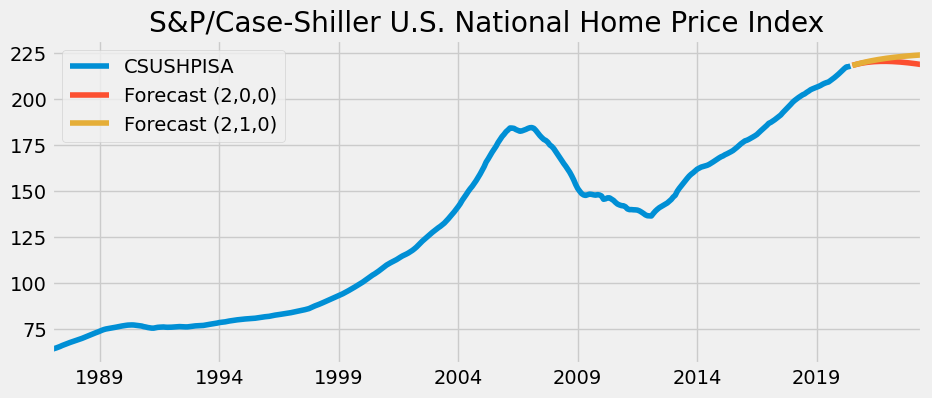

In [12]:
model_2 = ARIMA(data, order=(2,1,0),freq='MS')
model_fit2 = model_2.fit()
output_2 = model_fit2.forecast(steps=36,freq='MS')
forecast_2 = pd.concat([forecast_1,output_2],axis=1)
forecast_2.columns = [forecast_1.columns[0], 'Forecast (2,0,0)','Forecast (2,1,0)']
forecast_2.plot(figsize=(10,4))
plt.title('S&P/Case-Shiller U.S. National Home Price Index')
plt.show()

## Information Criterion Method

In [13]:
model = pm.auto_arima(data, 
                      d=1, 
                      D=1, 
                      seasonal=False, 
                      start_p=0, 
                      start_q=0, 
                      max_order=6, 
                      test='adf', 
                      max_p=6,
                      error_action='ignore',
                      suppress_warnings=True,
                      stepwise=True, 
                      trace=True)

Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=890.106, Time=0.04 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=42.310, Time=0.06 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=545.150, Time=0.06 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=986.047, Time=0.01 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=42.999, Time=0.09 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=43.090, Time=0.11 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=33.047, Time=0.24 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=35.042, Time=0.36 sec
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=35.042, Time=0.34 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=44.696, Time=0.15 sec
 ARIMA(3,1,0)(0,0,0)[0] intercept   : AIC=44.372, Time=0.11 sec
 ARIMA(3,1,2)(0,0,0)[0] intercept   : AIC=35.771, Time=0.52 sec
 ARIMA(2,1,1)(0,0,0)[0]             : AIC=34.104, Time=0.13 sec

Best model:  ARIMA(2,1,1)(0,0,0)[0] intercept
Total fit time: 2.235 seconds


/Users/pepar-mapillary/anaconda3/envs/monthly-report/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


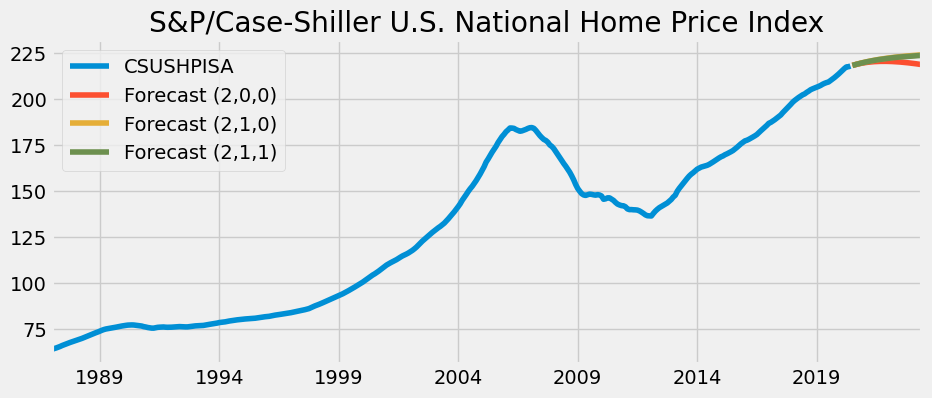

In [14]:
model_3 = ARIMA(data, order=(2,1,1),freq='MS')
model_fit3 = model_3.fit()
output_3 = model_fit3.forecast(steps=36,freq='MS')
forecast_3 = pd.concat([forecast_2,output_3],axis=1)
forecast_3.columns = [forecast_1.columns[0], 'Forecast (2,0,0)','Forecast (2,1,0)','Forecast (2,1,1)']
forecast_3.plot(figsize=(10,4))
plt.title('S&P/Case-Shiller U.S. National Home Price Index')
plt.show()

In [15]:
#table of forecasts
forecast_3.loc['2020-07-01':]

,CSUSHPISA,"Forecast (2,0,0)","Forecast (2,1,0)","Forecast (2,1,1)"
2020-07-01,NaN,218.394313,218.390303,218.369402
2020-08-01,NaN,218.701402,218.709183,218.703966
2020-09-01,NaN,218.980662,219.013912,218.985481
2020-10-01,NaN,219.233426,219.305204,219.290556
2020-11-01,NaN,219.460961,219.583645,219.544964
2020-12-01,NaN,219.664478,219.849803,219.823226
2021-01-01,NaN,219.845131,220.104219,220.053052
2021-02-01,NaN,220.004019,220.347411,220.306931
2021-03-01,NaN,220.142194,220.579875,220.514466
2021-04-01,NaN,220.260654,220.802084,220.746172


# 4. Forecast the future evolution of Case-Shiller Index using the ARMA model. Test model using in-sample forecasts.
## Forecast In-sample

The code below creates a ARIMA(2,0,0) model and uses in-sample predictions to measure model performance.

Results:

- Mean Error: -0.019769
- Mean Squared Error: 0.064668
- Mean Absolute Error: 0.147052
- Mean Absolute Percentage Error: 0.105726%
- Variance Explained: 0.999969

The simple ARMA(2,0,0) model performs quite well for in-sample forecasts. The variance explained is incredibly high at 0.999969 with MAPE of 0.105726%. There is a slight bais for the model to under forecast on average by -0.019769 (ME).

It is also important to note we are measuring model performance against data that was to used to fit the model. This means these performance metrics are most likely over-estimate the model's performance in production. It is important to use out of sample data to measure model performance because out of sample data would measure model performance on data it has not seen before.

In [16]:
#set size of historical data and size of "future" data
model = ARIMA(data['CSUSHPISA'].tolist(), order=(2,0,0))
#fit model
model_fit = model.fit()

In [17]:
#merge test data and 1 month incremental forecasts
ppd_pred = data.iloc[1:].copy()
#in-sample predictions
ppd_pred['Predictions (2,0,0)']=model_fit.predict()[1:]
ppd_pred['resid']=ppd_pred['Predictions (2,0,0)']-ppd_pred['CSUSHPISA']
ppd_pred['resid_rel']=ppd_pred['resid']/ppd_pred['CSUSHPISA']

ppd_pred.head(15)

,CSUSHPISA,"Predictions (2,0,0)",resid,resid_rel
DATE,,,,
1987-02-01,64.448,63.993701,-0.454299,-0.007049
1987-03-01,64.761,64.893503,0.132503,0.002046
1987-04-01,65.152,65.067649,-0.084351,-0.001295
1987-05-01,65.582,65.532752,-0.049248,-0.000751
1987-06-01,66.087,65.999771,-0.087229,-0.001320
1987-07-01,66.519,66.576007,0.057007,0.000857
1987-08-01,66.949,66.938540,-0.010460,-0.000156
1987-09-01,67.343,67.366578,0.023578,0.000350
1987-10-01,67.755,67.726295,-0.028705,-0.000424


In [18]:
#performance metrics
print('Mean Error: {:f}'.format(ppd_pred.resid.mean()))

print('Mean Squared Error: {:f}'.format(mean_squared_error(ppd_pred['CSUSHPISA'],
                                                           ppd_pred['Predictions (2,0,0)'])))

print('Mean Absolute Error: {:f}'.format(mean_absolute_error(ppd_pred['CSUSHPISA'],
                                                             ppd_pred['Predictions (2,0,0)'])))

print('Mean Absolute Percentage Error: {:f}%'.format(ppd_pred['resid_rel'].abs().mean()*100))

print('Variance Explained: {:f}'.format(explained_variance_score(ppd_pred['CSUSHPISA'],
                                                                 ppd_pred['Predictions (2,0,0)'])))

Mean Error: -0.019769
Mean Squared Error: 0.064668
Mean Absolute Error: 0.147052
Mean Absolute Percentage Error: 0.105726%
Variance Explained: 0.999969


## Visualize Predictions, Residuals and Percentage Residuals

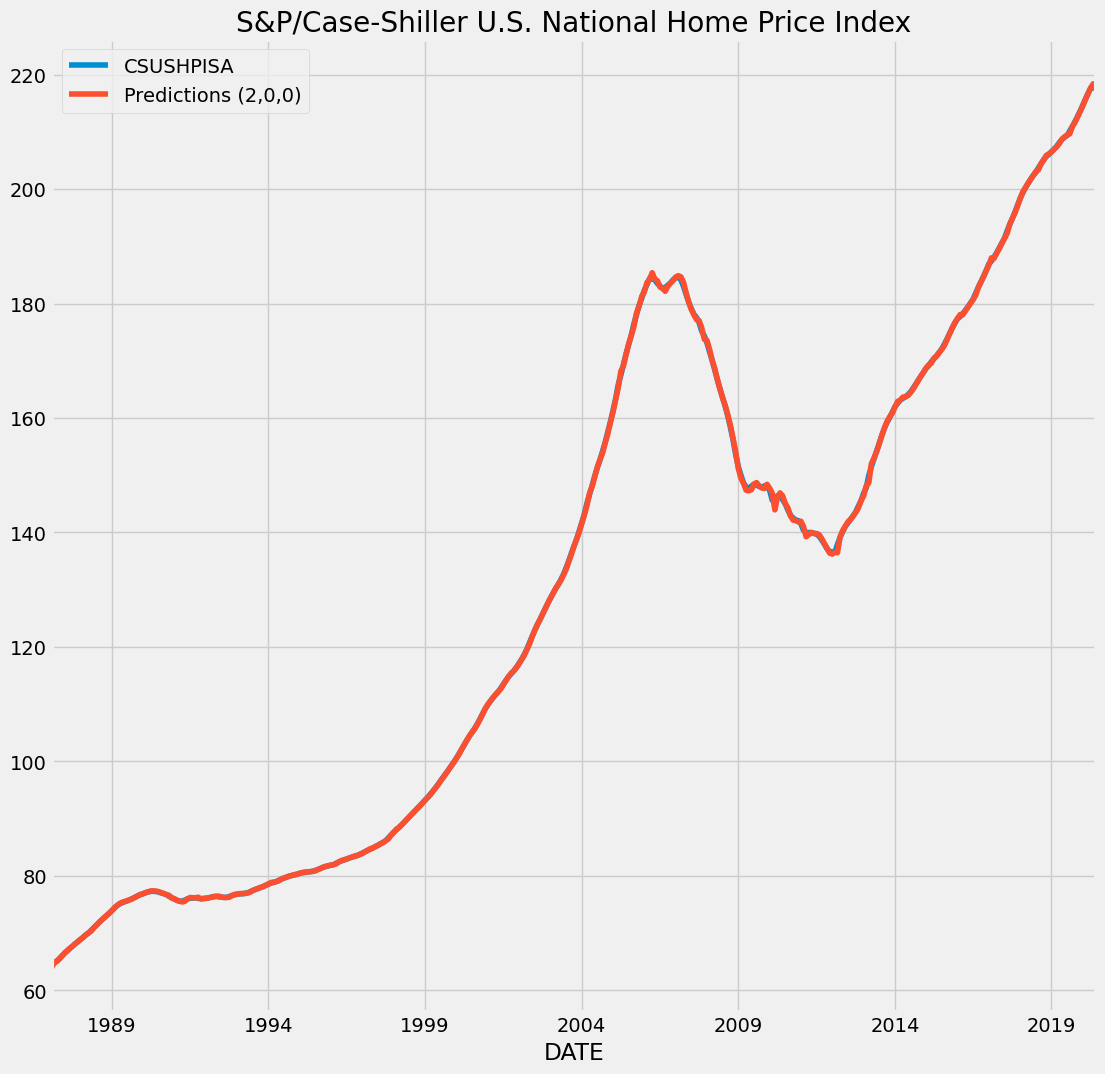

In [19]:
#plot actuals and forecast
ppd_pred[['CSUSHPISA','Predictions (2,0,0)']].plot()
plt.title('S&P/Case-Shiller U.S. National Home Price Index')
plt.show()

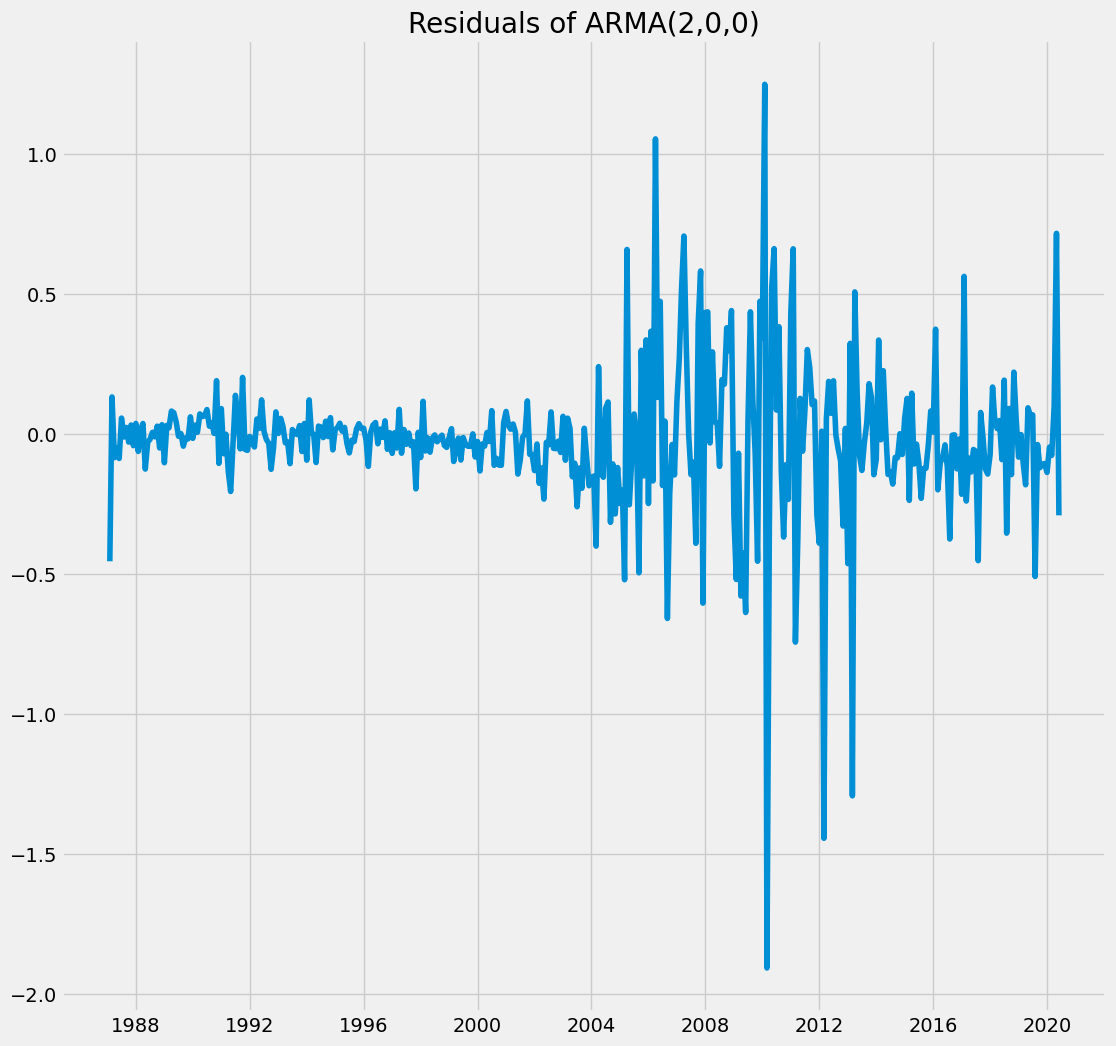

In [20]:
#plot residuals
plt.plot(ppd_pred[['resid']])
plt.title('Residuals of ARMA(2,0,0)')
plt.show()

/Users/pepar-mapillary/anaconda3/envs/monthly-report/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: FixedFormatter should only be used together with FixedLocator
  """


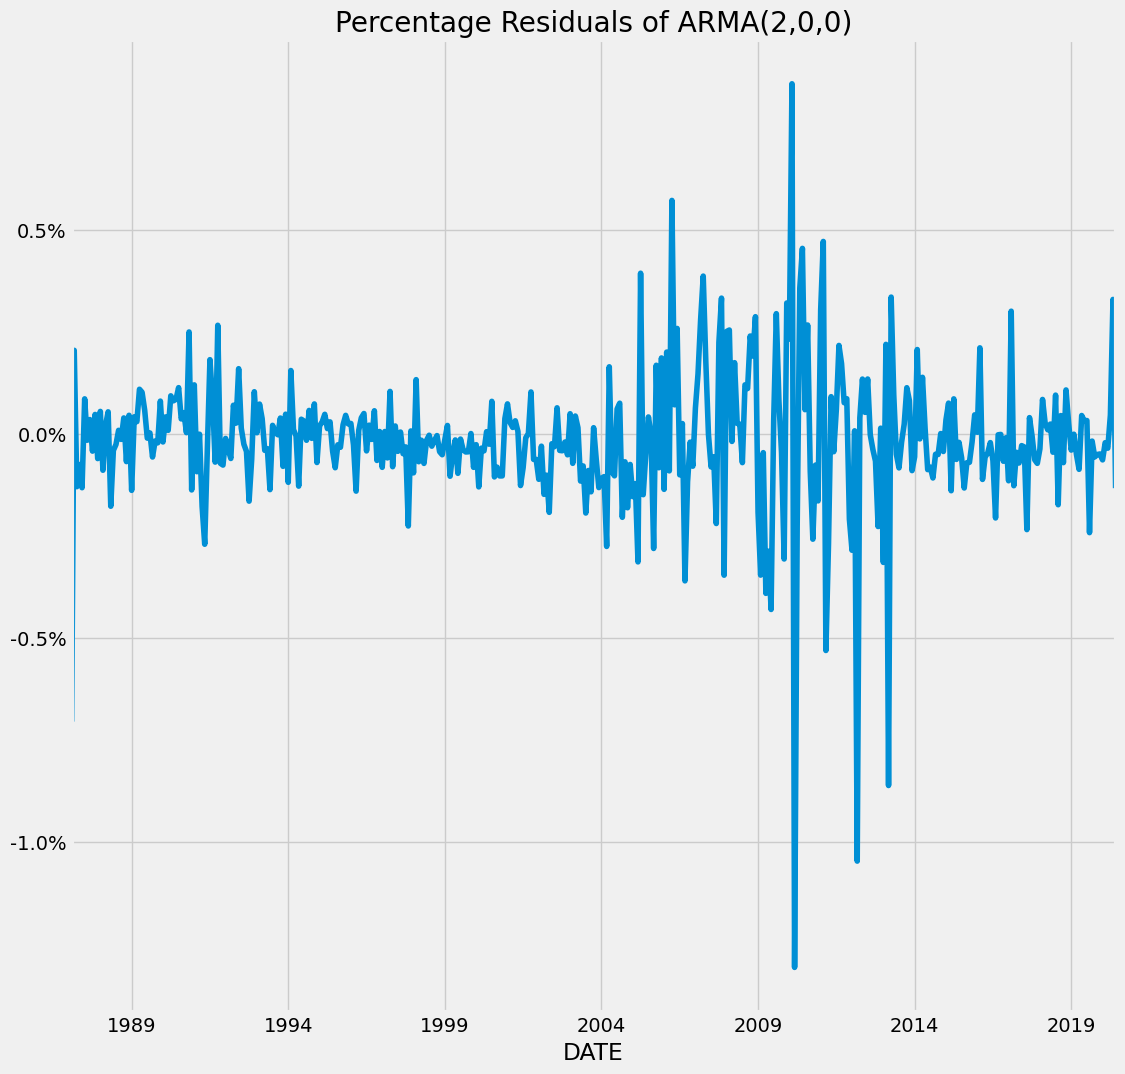

In [21]:
#plot precentage residuals
ax = ppd_pred['resid_rel'].plot()
# set ticks to percentage
vals = ax.get_yticks()
ax.set_yticklabels(['{:,.1%}'.format(x) for x in vals])
plt.title('Percentage Residuals of ARMA(2,0,0)')
plt.show()

In [23]:
#export to other file formats
!jupyter nbconvert --to html "Univariate Time Series.ipynb"
!jupyter nbconvert --to python "Univariate Time Series.ipynb"

[NbConvertApp] Converting notebook Univariate Time Series.ipynb to html
[NbConvertApp] Writing 1259178 bytes to Univariate Time Series.html
[NbConvertApp] Converting notebook Univariate Time Series.ipynb to python
[NbConvertApp] Writing 14321 bytes to Univariate Time Series.py
